In [52]:
import pickle
from tkinter import messagebox
from tkinter import filedialog
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os

In [53]:
def ui_load_ixxt_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo CSV",
            filetypes=(("CSV files", "*.csv"), ("all files", "*.*"))
        )
    
    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = ixxt_filetodataframe(file_path)  # Simulação do carregamento de dados
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [54]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 itens
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal
        byte_list = [int(byte, 16) for byte in byte_list]

        return byte_list  # Retorna a lista para ser expandida em colunas
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")


In [55]:
def ixxt_filetodataframe(file_path):
    df = pd.read_csv(file_path, sep=';', quotechar='"', skiprows=6)
    df = df.dropna(subset=['Data (hex)'])
    df['Identifier (hex)'] = df['Identifier (hex)'].apply(lambda x: int(x, 16))

    byte_columns = df['Data (hex)'].apply(process_data)

    byte_columns = pd.DataFrame(byte_columns.tolist(), index=df.index, columns=[f'byte_{i + 1}' for i in range(8)])
    print(byte_columns)
    columns_to_drop = ['Format', 'Flags', 'Time', 'Data (hex)']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = pd.concat([df, byte_columns], axis=1)
    df = df.rename(columns={'Identifier (hex)': 'pgn'})
    return df


In [56]:
def decimacao_dinamica(df, coluna, tamanho):
    
    df[coluna] = df[coluna].apply(lambda x: list(map(int, x.split())) if isinstance(x, str) and x.strip() else [])

    def decimar_lista(lst, tamanho_fixo):
        if len(lst) == 0:
            print(f"Lista vazia, preenchendo com zeros até {tamanho_fixo} elementos.")
            return [0] * tamanho_fixo  # Se a lista estiver vazia, retorna uma lista de zeros
        elif len(lst) == tamanho_fixo:
            print(f"Lista já está no tamanho fixo ({tamanho_fixo}).")
            return lst  # Se já estiver no tamanho fixo, retorna a lista original
        elif len(lst) > tamanho_fixo:
            # Se a lista for maior, faz a decimação (subsample)
            step = len(lst) // tamanho_fixo  # Calcula o passo necessário
            decimated_lst = lst[::step][:tamanho_fixo]  # Fatiamento
            print(f"Lista maior que o tamanho' fixo ({len(lst)} > {tamanho_fixo}). Aplicando decimação.")
            print(f"Lista decimada: {decimated_lst}")
            return decimated_lst
        else:
            # Se for menor, preenche com zeros até atingir o tamanho
            filled_lst = lst + [0] * (tamanho_fixo - len(lst))
            print(f"Lista menor que o tamanho fixo ({len(lst)} < {tamanho_fixo}). Preenchendo com zeros.")
            print(f"Lista preenchida: {filled_lst}")
            return filled_lst

    print(f"dataframe antes decimaçao:{df}")
    # Aplicar a decimação dinâmica na coluna
    df[coluna] = df[coluna].apply(lambda lst: decimar_lista(lst, tamanho))

    print("\nApós a decimação dinâmica:")
    print(df[coluna])

    return df

In [57]:
def normalizar_dataframe(df):
    if df_decimado is None or df_decimado.empty:
        print("Aviso: O DataFrame está vazio ou não foi carregado.")
        return None
    
    try:
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for i in range(len(df)):
            data = np.array(df.loc[i, 'x']).reshape(-1, 1)

            # Aplicar o fit_transform para a linha atual
            data_normalized = scaler.fit_transform(data)
            
            # Substituir a linha normalizada no DataFrame
            df_decimado.loc[i, 'x'] = data_normalized.flatten().tolist()
            
            with open('scaler.pkl', 'wb') as f:
            
              pickle.dump(scaler, f)

        return df_decimado
    except Exception as e:
        print(f"Erro ao normalizar o DataFrame: {str(e)}")
        return None


In [58]:
def filtrar_dataframe(df, pgn, byte):

    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == int(pgn, 16)]  # Se pgn for uma string hexadecimal

            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

In [59]:
def vizdata(df):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    # Visualização da coluna específica
    plt.figure(figsize=(20, 10), dpi=100)
    plt.plot(range(len(df)), df['x'], linestyle='-', color='b',
                linewidth=0.7, label='x')
    plt.xlabel('X')
    plt.ylabel('Value')
    plt.title(f"Visualização de Dados - PGN: {filtro_pgn}, Byte: {filtro_byte}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [60]:
def rotular_df(df, label):

    label_dict = {
        "Onda Quadrada": 1,
        "Onda Seno": 0,
    }

    # Verifica se o rótulo textual existe no dicionário
    if label not in label_dict:
        raise ValueError(f"Rótulo '{label}' não é válido. Use 'Onda Quadrada', 'Onda Seno' ou 'Onda Triangular'.")
    
    numeric_label = label_dict[label]

    if df is None:
        raise ValueError("O dataframe está vazio, carrega 'treino'")
    else:
        # Preencher o DataFrame com o valor numérico correspondente
        rotuled_df = df.copy()
        rotuled_df['label'] = numeric_label

    return rotuled_df


In [61]:
def concatenate_dataframes(df_list):
    rows = []
    
    # Iterar sobre cada DataFrame na lista
    for df in df_list:
        # Concatenar os valores da coluna 'X' em ma única célula
        concatenated_x = ' '.join(map(str, df['x'].tolist()))
        # Adicionar à lista de resultados como um dicionário
        rows.append({'x': concatenated_x})
    
    # Converter a lista de dicionários para um DataFrame
    concatenated_df = pd.DataFrame(rows)
    
    return concatenated_df

In [62]:
def plot_line_for_each_row(df):
    if 'x' not in df.columns:
        raise ValueError("O DataFrame deve conter uma coluna 'x'")
    
    # Iterar sobre cada linha do DataFrame
    for index, row in df.iterrows():
        # Como a coluna 'x' já contém listas de valores, podemos usá-las diretamente
        values = row['x']  # Já é uma lista de floats ou inteiros
        
        plt.plot(values, label=f"Sinal {index + 1}")
    
    # Adicionar rótulos e título ao gráfico
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.title("Gráfico de Linhas para Cada Linha do DataFrame")
    plt.legend()
    plt.show()

In [63]:
def save_df_train(train_df):
    if train_df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame de treino completo"
    )

    if save_path:
        train_df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame de treino salvo com sucesso!")

In [64]:
def rows_replicate_dataframes(df, target_size):
    if 'x' in df.columns:
        num_rows = len(df)  # Número de linhas no dataframe original
        #df_result = pd.DataFrame(columns=['x'])
        
        replication_factor = target_size // num_rows
        #remainder = target_size % num_rows  # Calcula o restante para garantir exatamente 2000 linhas

        # Primeiro loop para percorrer cada linha do dataframe original
        rows = []
        for i in range(len(df)):
            value = df.iloc[i, 0]  # Obtém o valor da primeira coluna (coluna 'x')

            # Segundo loop para repetir o valor 10 vezes
            for _ in range(replication_factor):
                rows.append(value)

        # Concatena as listas no DataFrame final
        df_result = pd.concat([pd.DataFrame({'x': rows})], ignore_index=True)

        return df_result
    else:
        return "Coluna 'x' não encontrada"


# IXXT-SquareWaves

# JUMPY 2024
## Velocidade

In [65]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier")
df_raw_1 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/JUMPY 2024/velocidade_0_20_5x_jumpy.CSV")

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          24      72      48       0      76      50      48      48
1          48      48       0      97     187     164      32       0
2          50       0     240       0       0       0       0       0
3          24       0       0       1       0      82       0       0
4         255     153       0       7     173       0      32       0
...       ...     ...     ...     ...     ...     ...     ...     ...
69062       0       0      13     156     175     198      70       0
69063       0       0       0       3       0       0       0       0
69064       0       0       0       0       0       0       0       0
69065      32       9      64       2     208       7       0       0
69066       0      80       0       7      19       0      32       0

[69045 rows x 8 columns]


In [66]:
filtro_byte = 3
filtro_pgn = '32d'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_3 e 32d


In [67]:
filtered_df_one = filtrar_dataframe(df_raw_1, filtro_pgn, filtro_byte)

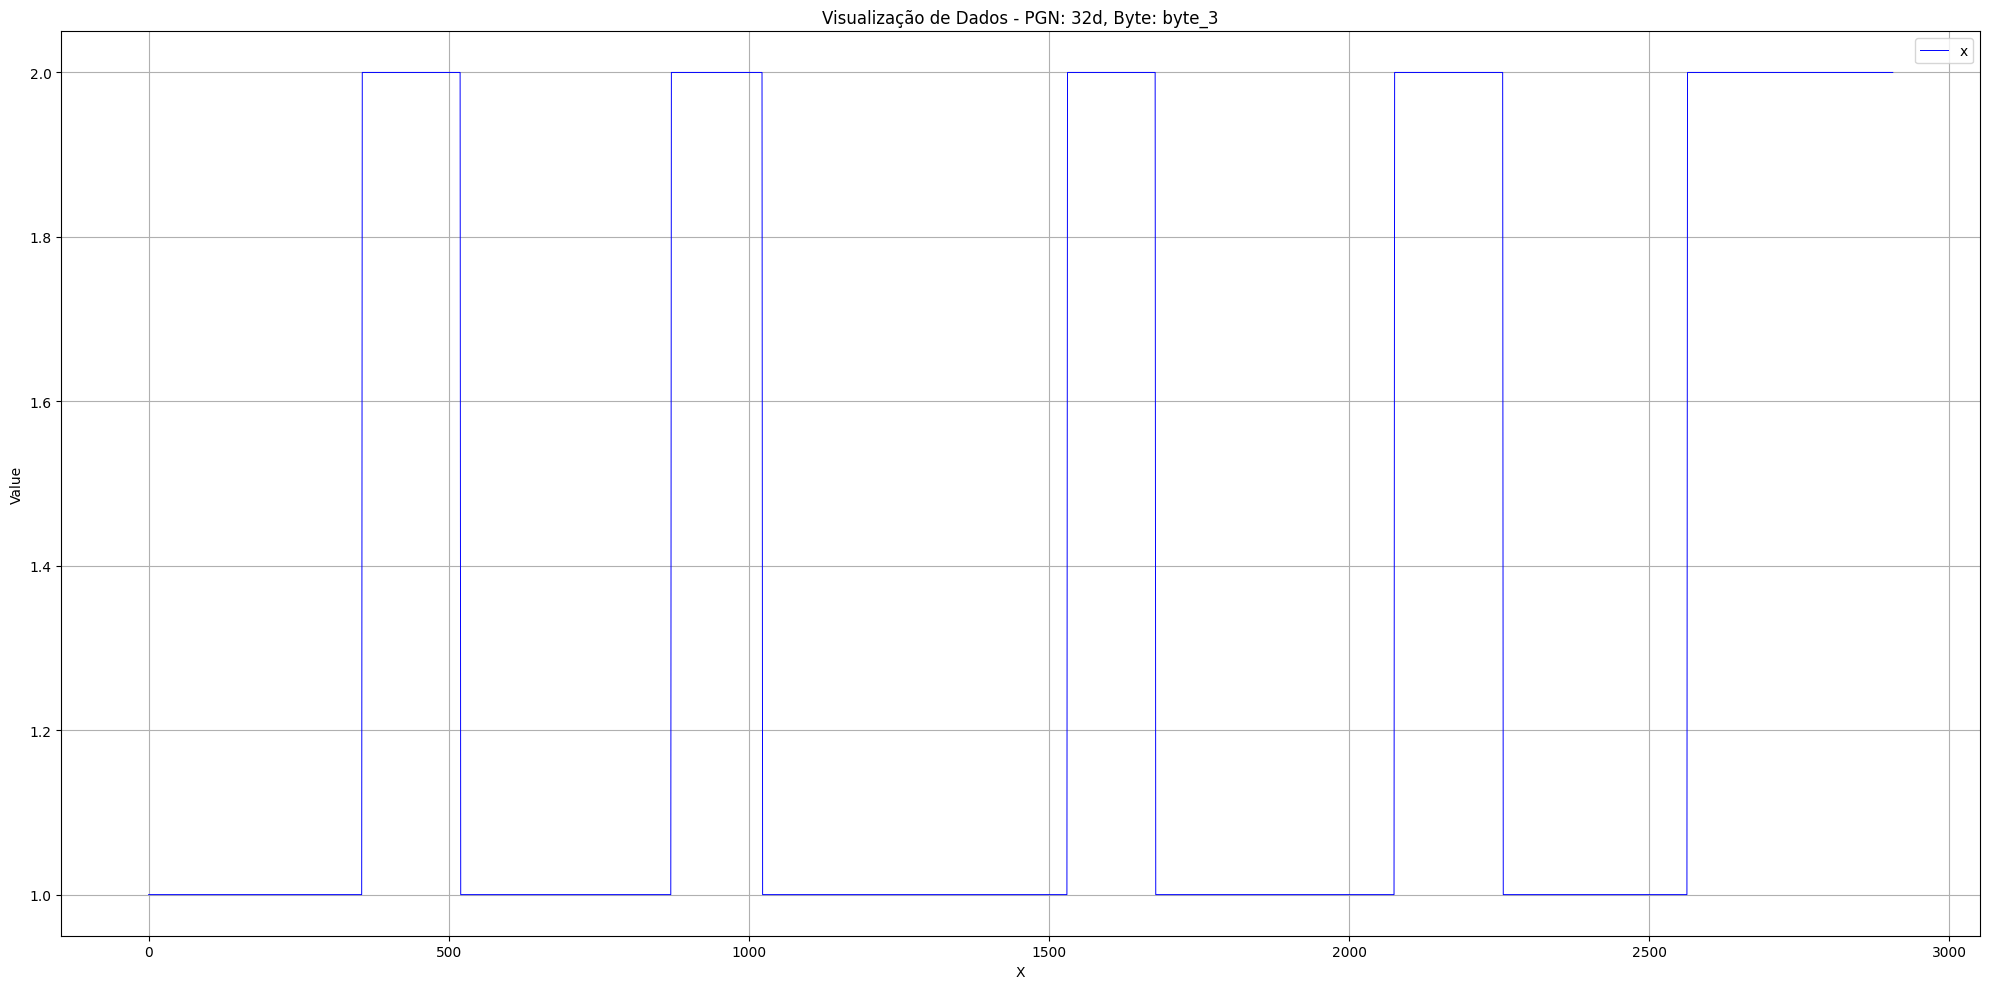

In [68]:
vizdata(filtered_df_one)

# Corola 2013
## Farol (7)

In [69]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_7 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/Corolla 2013/Corolla_2013_Farol.csv") 
filtro_byte = 4
filtro_pgn = '622'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_seven = filtrar_dataframe(df_raw_7, filtro_pgn, filtro_byte)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0     105       0       0       0
1           8       0       0       0      50     223       0     228
2           0       0       0       0       0      13       0       0
3           0       0       0       0       0      13       0       0
4           0       0       0       0       0       0       0     188
...       ...     ...     ...     ...     ...     ...     ...     ...
10937       0       0       0       0       0       5       0       0
10938       0       0       0       0       0       0       0     188
10939       0       0       0       0       0       5       0       0
10940       0       0       0     127     224       0       0     140
10941       8       0       0       0      40     221       0     216

[10942 rows x 8 columns]
byte_4 e 622


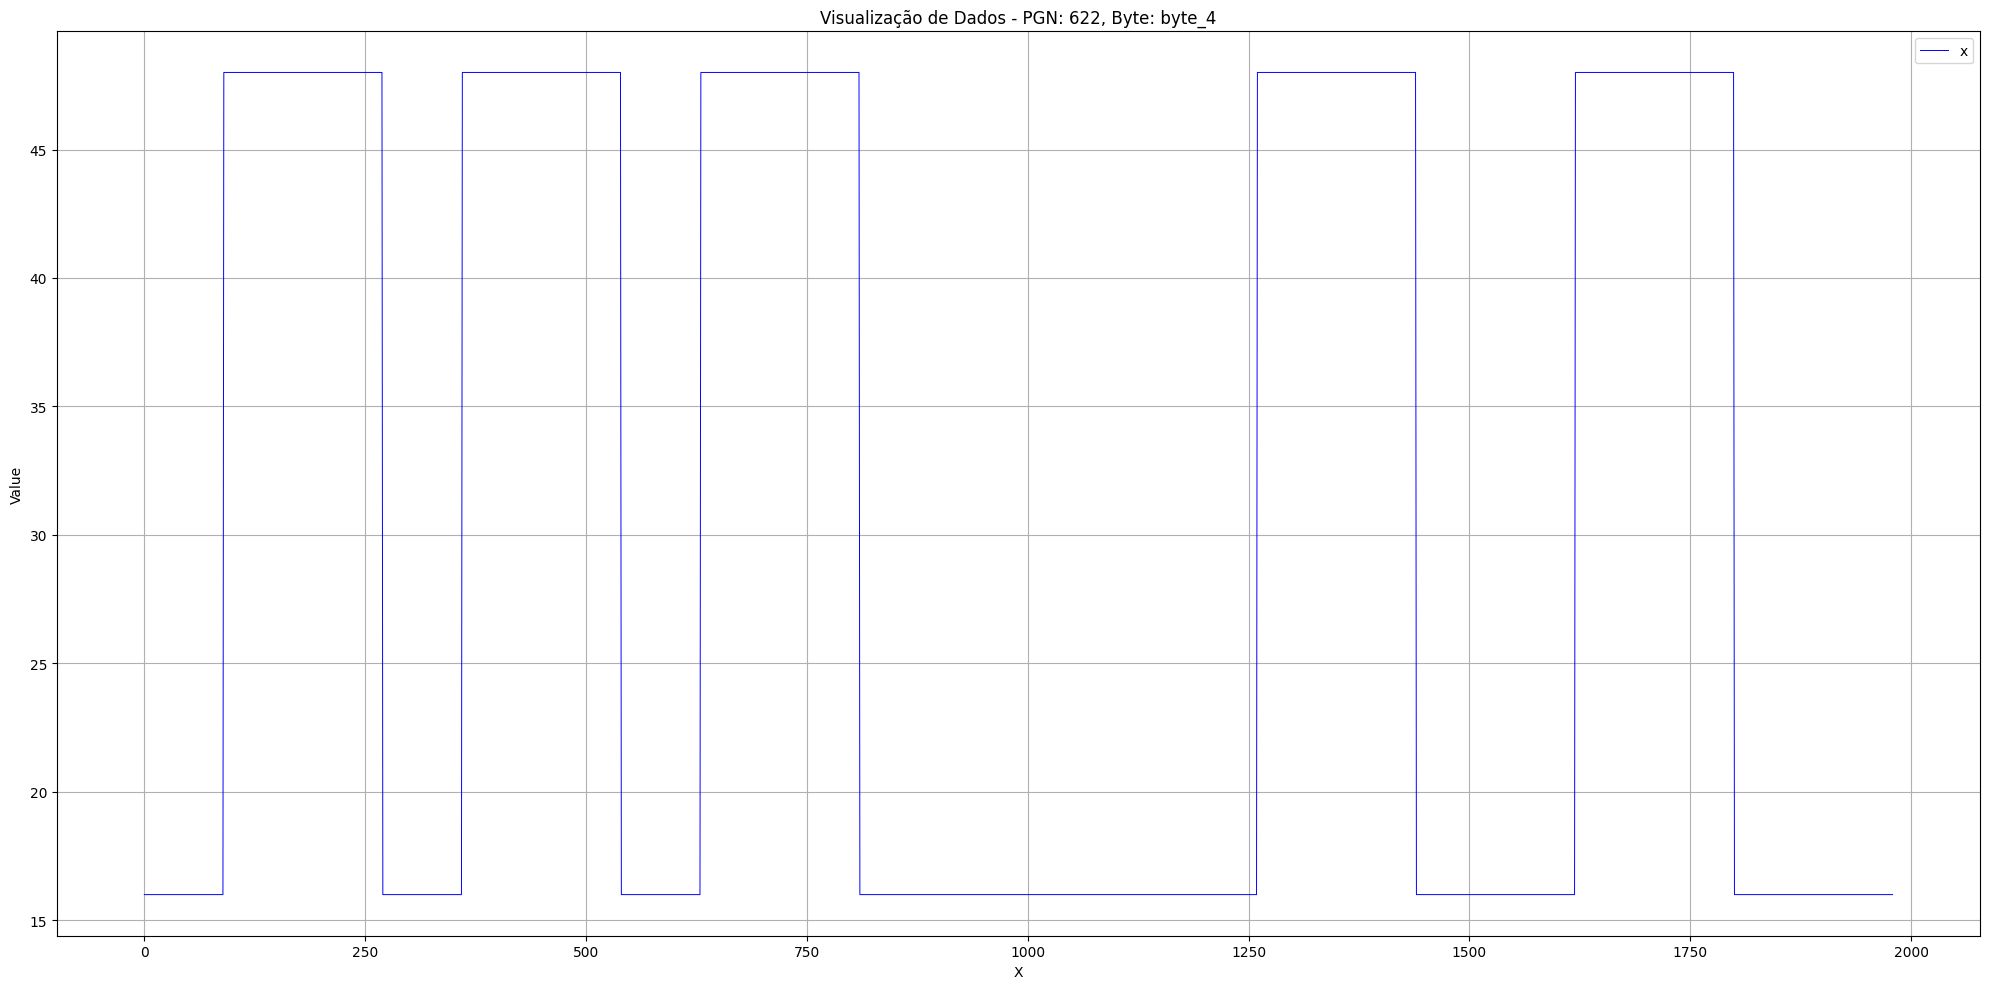

In [70]:
df_expanded_seven = rows_replicate_dataframes(filtered_df_seven, target_size=2000)
vizdata(df_expanded_seven)

In [71]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_8 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/Corolla 2013/Corolla_2013_Freio.csv") 
filtro_byte = 5
filtro_pgn = '3b4'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_seven = filtrar_dataframe(df_raw_8, filtro_pgn, filtro_byte)

      byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          8       0       0      16      45     192       0     208
1          0       0       0       0     105       0       0       0
2          0       0       0       0       0       3       0       0
3          0       0       0       0       0       3       0       0
4          0       0       0       0       0       0       0     188
...      ...     ...     ...     ...     ...     ...     ...     ...
5992       0       0       0       0       0       0       0     208
5993       0       0       0       0     105       0       0       0
5994       0       0       0       0       0      12       0       0
5995       0       0       0       0       0      12       0       0
5996       0       0       0      37       0       0      98      85

[5997 rows x 8 columns]
byte_5 e 3b4


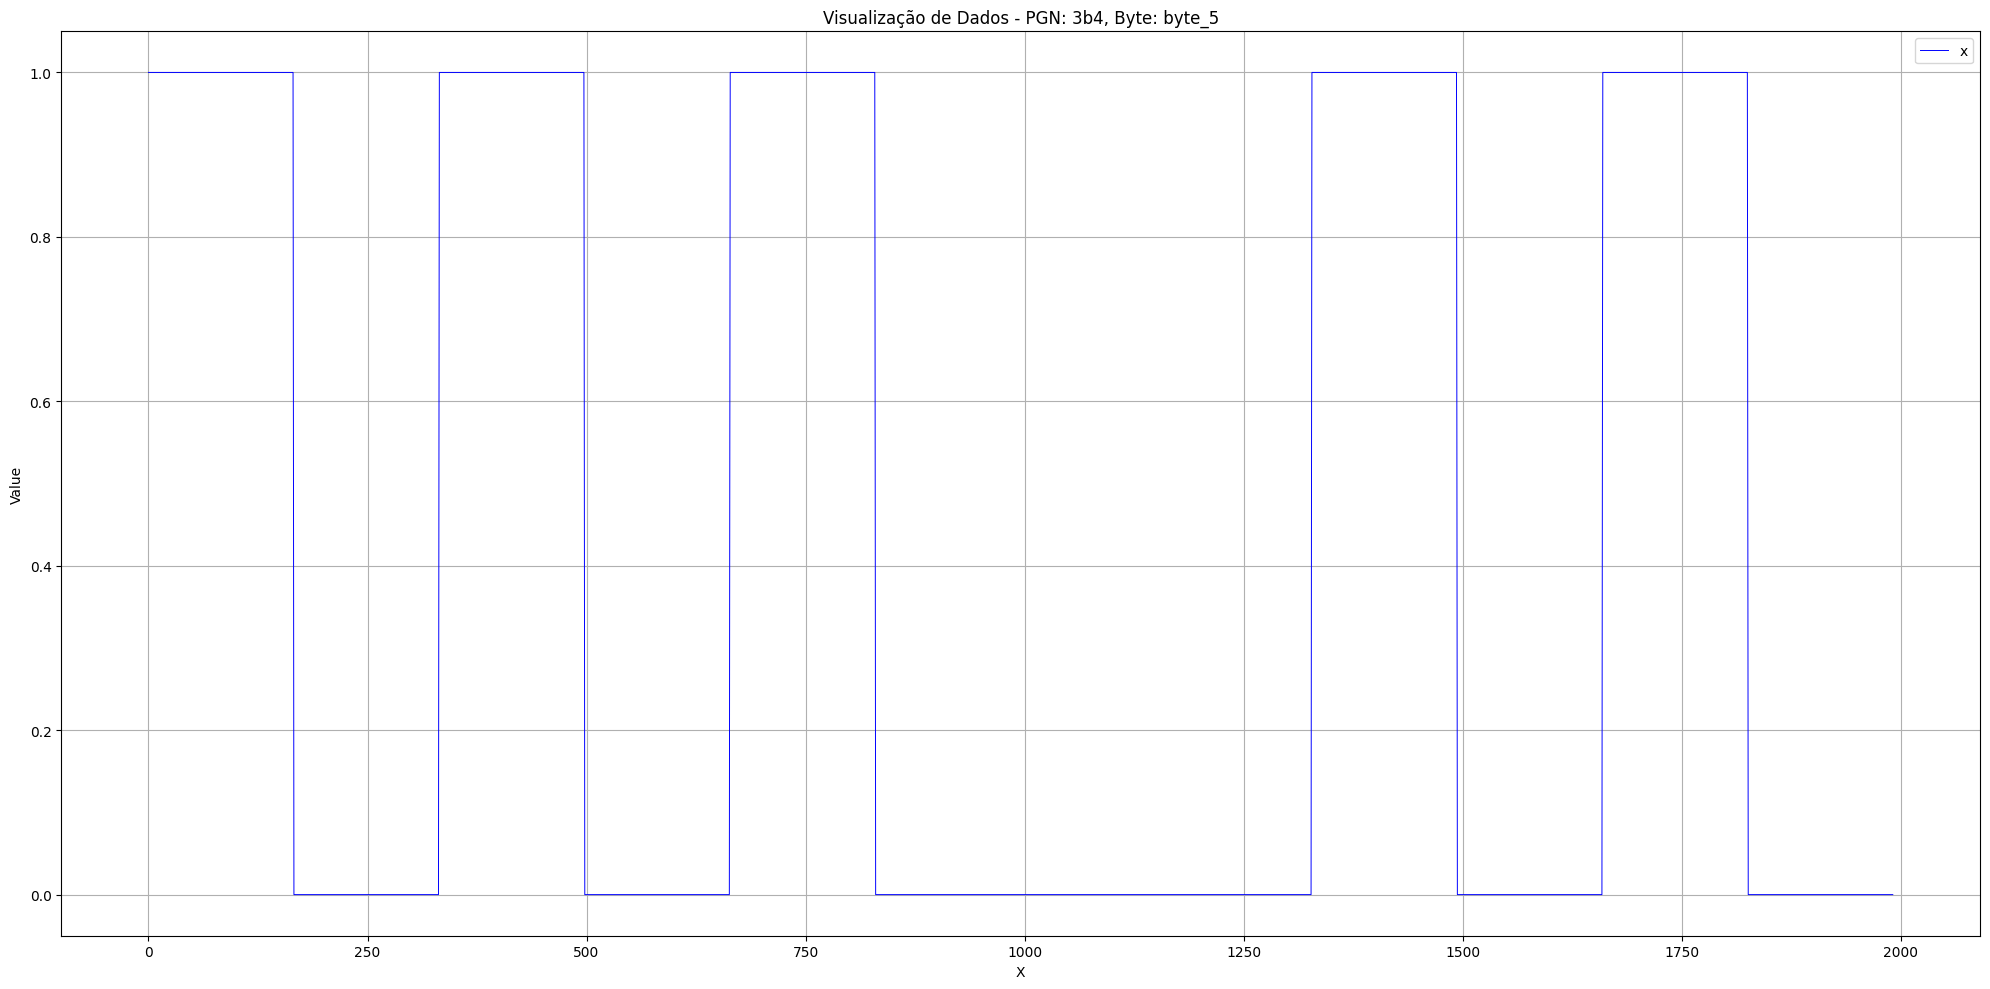

In [72]:
df_expanded_eight = rows_replicate_dataframes(filtered_df_seven, target_size=2000)
vizdata(df_expanded_eight)

In [73]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_9 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/Fiat Toro AT D4 2016/Fiat_Toro_AT _D4_2016_Cinto.CSV") 
filtro_byte = 3
filtro_pgn = '257'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_nine= filtrar_dataframe(df_raw_9, filtro_pgn, filtro_byte)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          12       0       3     232       0       0       3      95
1           0       0       0       6       0       0       9     150
2           0       0       0       0       0       0       3      45
3           0       0       0       0       0       0       0       0
4           0       0       0       0       0       0       4     126
...       ...     ...     ...     ...     ...     ...     ...     ...
55495       0       0     147     205       0       0       0       0
55496      78     185     215      58     224       0       6      86
55497     128       1       0       0       0       0       0       0
55498       0       0      14      50     128       0       0       0
55499       0       0       0       0       0       0       7      89

[55500 rows x 8 columns]
byte_3 e 257


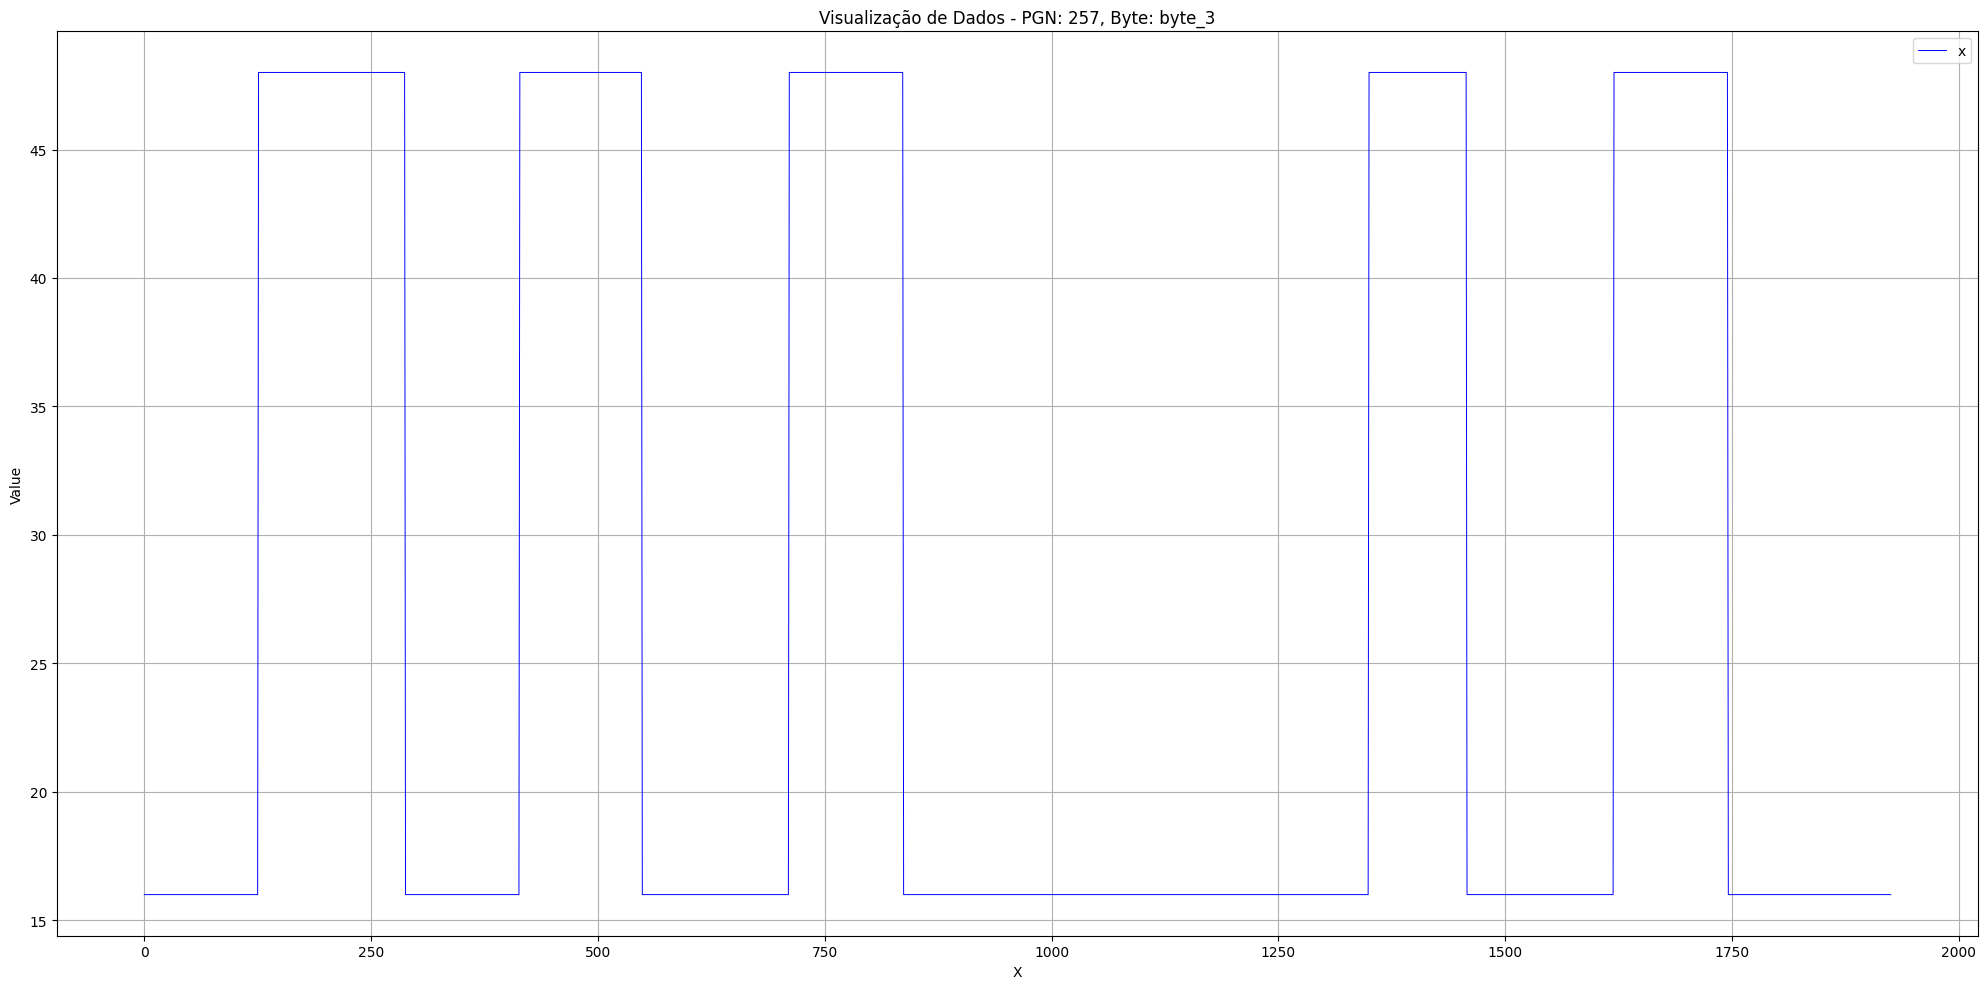

In [74]:
df_expanded_nine = rows_replicate_dataframes(filtered_df_nine, target_size=2000)
vizdata(df_expanded_nine)

In [75]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_10 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/Fiat Toro AT D4 2016/Fiat_Toro_AT _D4_2016_Farol.CSV") 
filtro_byte = 4
filtro_pgn = '384'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_ten = filtrar_dataframe(df_raw_10, filtro_pgn, filtro_byte)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       6      24       0       0       0
1          15     112       0       0       0       0       0       0
2           0       0     147     206       0       0       0       0
3          64      32       0       0       0       8       0     166
4           0       0       0       0       0       0       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
54915       0      12      34       0       0       0       0       0
54916     255     192       0      81      95     248       2      95
54917       0       0       0       6       0       0       2      89
54918       0      31     224       0       0       0       0       0
54919      78     177     214      58     192       0      13     201

[54920 rows x 8 columns]
byte_4 e 384


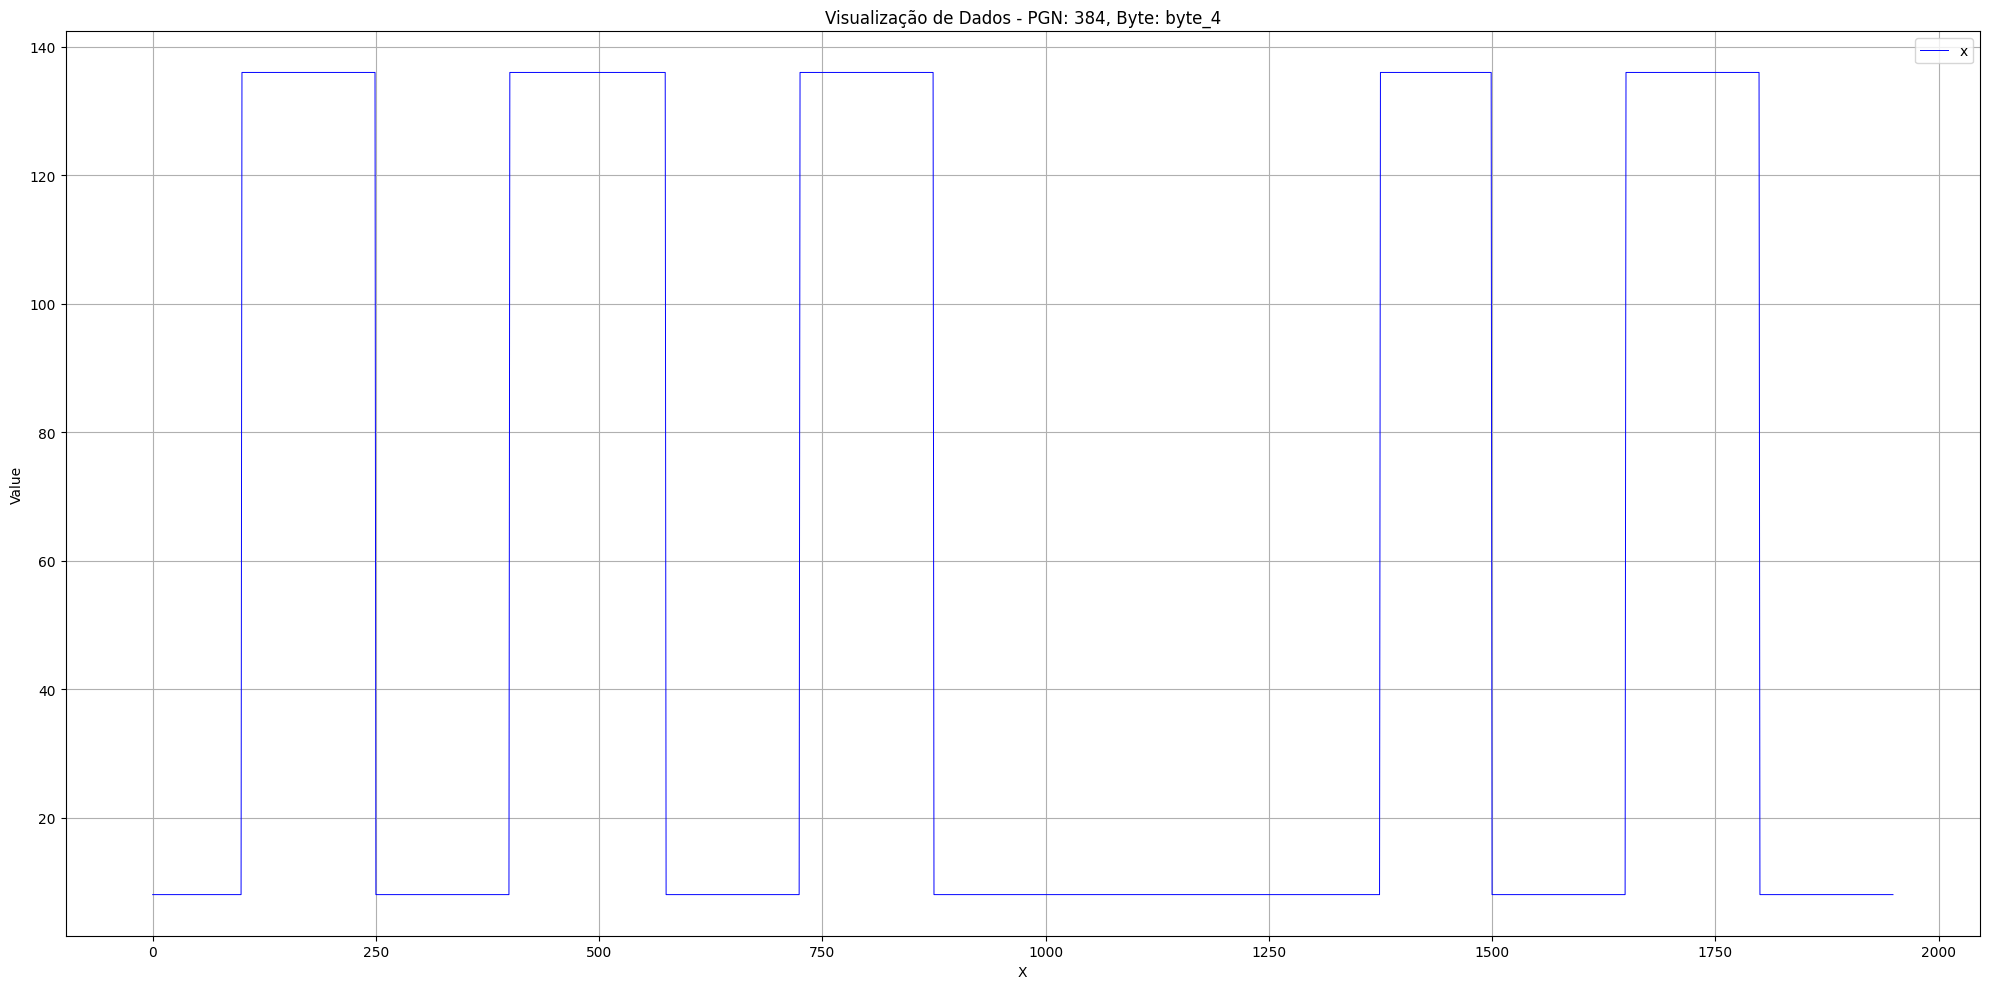

In [76]:
df_expanded_ten = rows_replicate_dataframes(filtered_df_ten, target_size=2000)
vizdata(df_expanded_ten)

## Freio

In [77]:
df_raw_2 = ui_load_ixxt_archive("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/Spy Can Input CSV/ixxat_data/JUMPY 2024/pedal_freio_5x_jumpy.CSV") 
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")

# Agora os caminhos relativos serão relativos a este diretório
df_raw_2 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/JUMPY 2024/pedal_freio_5x_jumpy.csv")

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0         255     253       0       0      11      34      96     185
1         127     192       1       0     128       0       0       0
2           0       0      50       0      12      50      50      50
3          50       0       0      55       0       4       0       0
4         255     196       0       7      75       0      32       0
...       ...     ...     ...     ...     ...     ...     ...     ...
13182       0       0      50       0      12      50      50      50
13183      50       0       0      55       0       4       0       0
13184       0      50      41      50     193       1      68       0
13185     255     196       0       7      75       0      32       0
13186       8       0       0       0       0       0       0       0

[13187 rows x 8 columns]
       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0         255     253       0       0      11      34      96   

In [78]:
filtro_byte = 3
filtro_pgn = '32d'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_two = filtrar_dataframe(df_raw_2, filtro_pgn, filtro_byte)

byte_3 e 32d


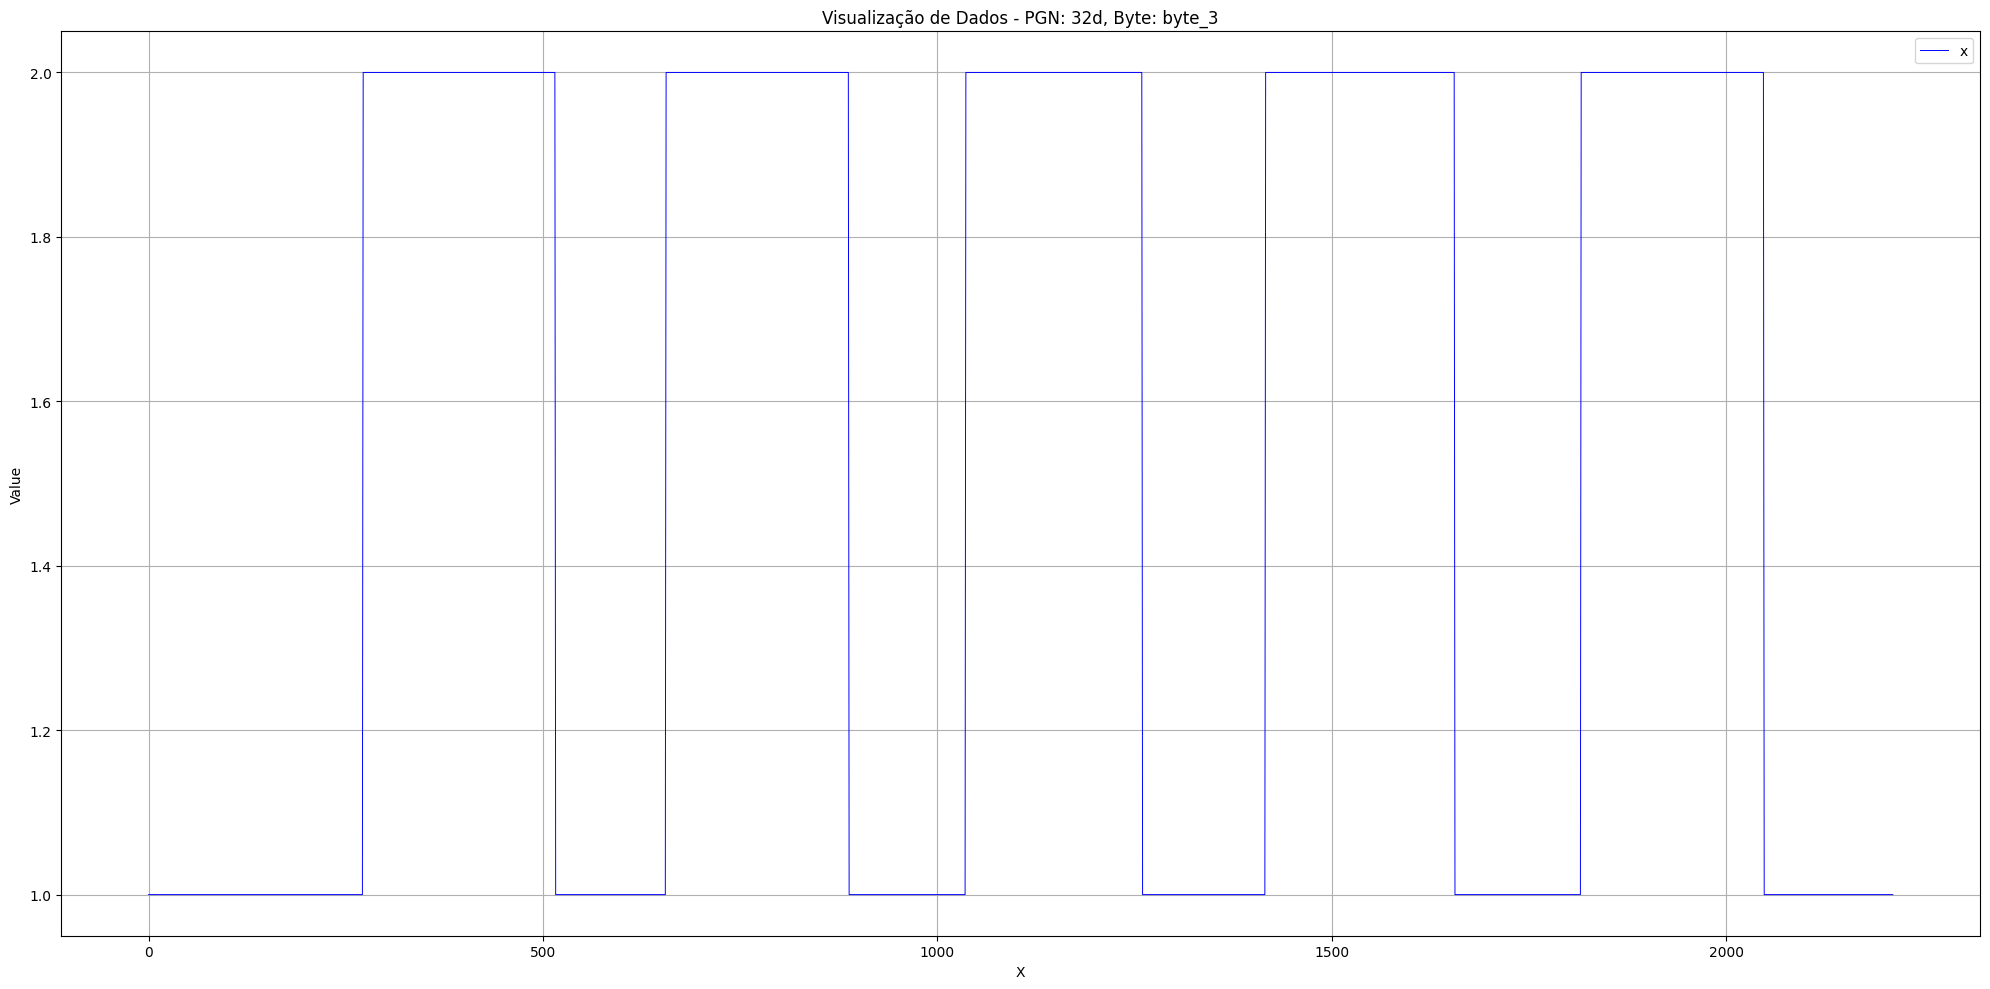

In [79]:
df_expanded_two = rows_replicate_dataframes(filtered_df_two, target_size=2500)
vizdata(df_expanded_two)

## Limpador

In [80]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")

# Agora os caminhos relativos serão relativos a este diretório
df_raw_3 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/JUMPY 2024/limpador_vel1_5x_jumpy.CSV")

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          93       0       0       0       0       0       0       0
1           0       0       0       0     175     215      70       0
2           0       0       0       0       0       0       0       0
3         255     195       0       7     196       0      32       0
4          25     168      49       0      76      50      49      49
...       ...     ...     ...     ...     ...     ...     ...     ...
16069     127     192       1       0     128       0       0       0
16070      25     128      47       0      76      50      47      47
16071      47      48       0     138       0     161      32       0
16072      50       0     240       0       0       0       0       0
16073     255     195       0       7     110       0      32       0

[16074 rows x 8 columns]


In [81]:
filtro_byte = 2
filtro_pgn = '348'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_2 e 348


In [82]:
filtered_df_three = filtrar_dataframe(df_raw_3, filtro_pgn, filtro_byte)
df_expanded_three = rows_replicate_dataframes(filtered_df_three, target_size=2000)
filtered_df_three.head()

,x
17,37
36,37
63,37
83,37
108,37


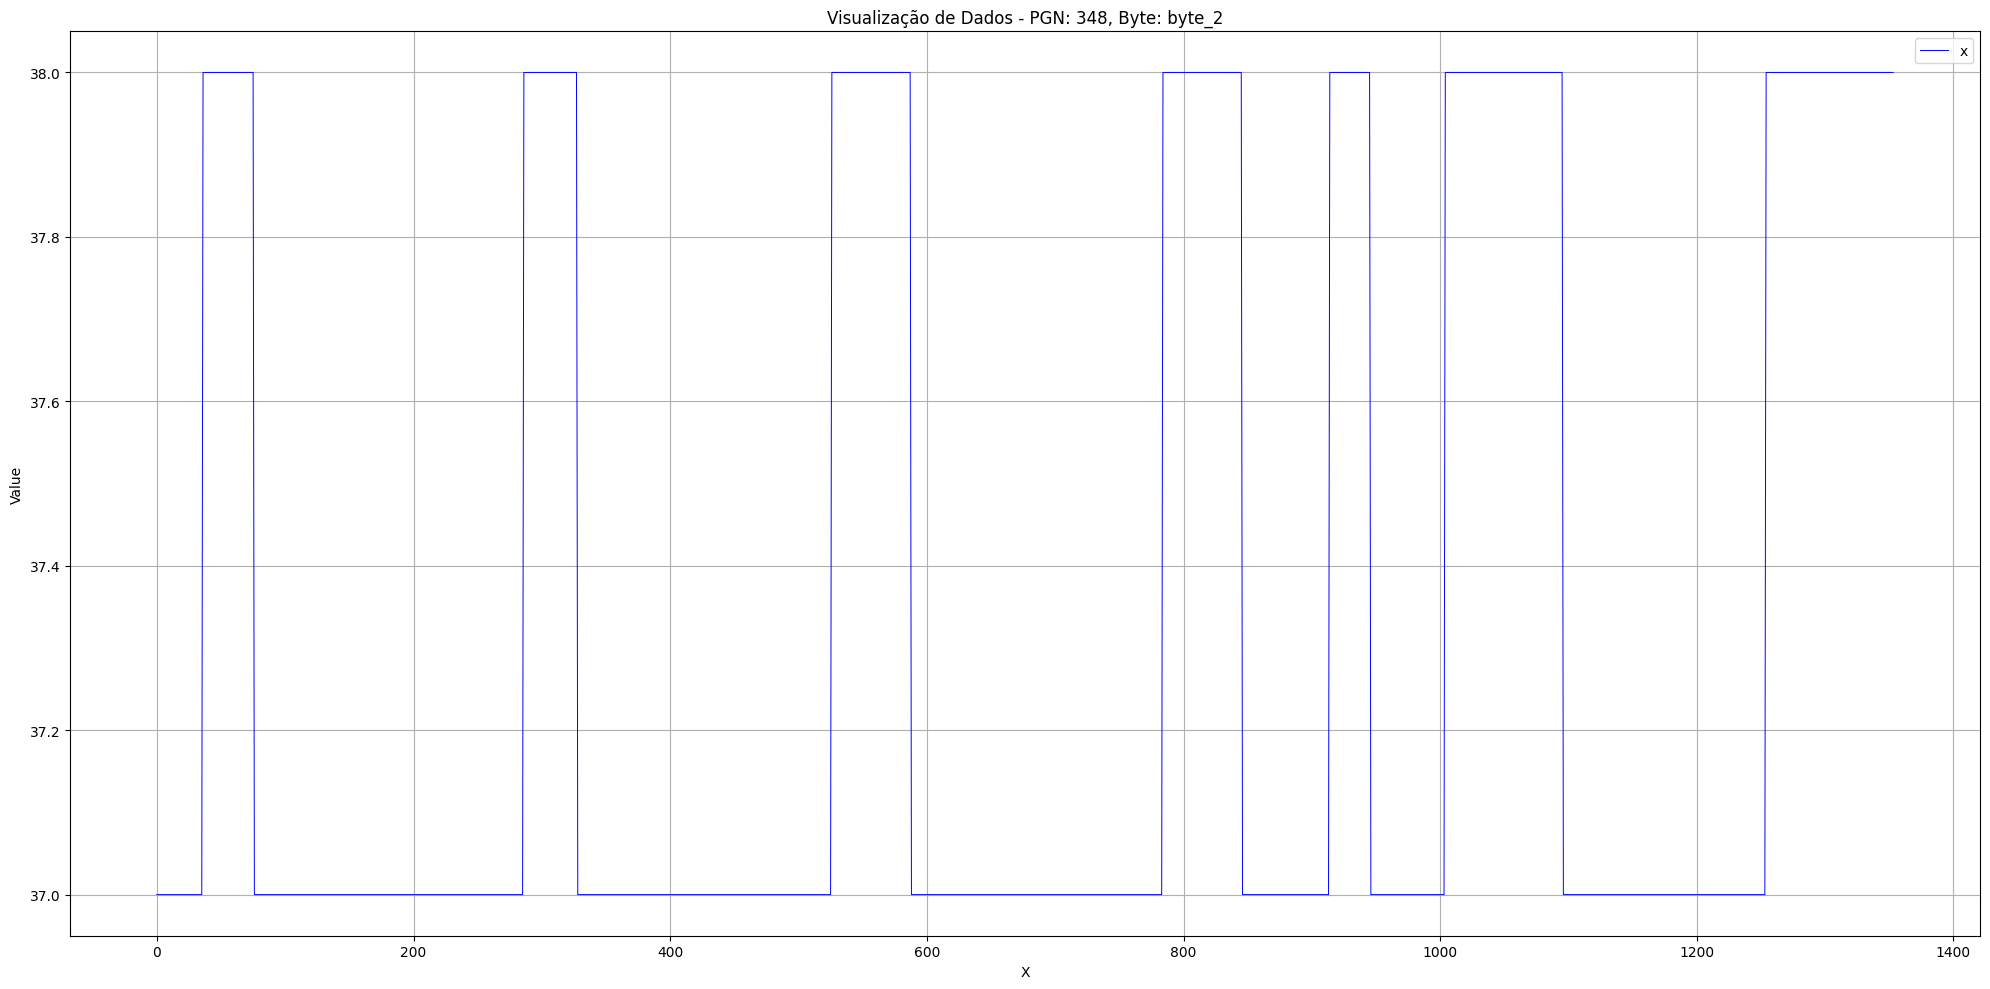

In [83]:
# vizdata(filtered_df_three)
vizdata(df_expanded_three)

# KALMAR
## Limpador

In [84]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_4 = ui_load_ixxt_archive('Spy Can Input CSV/ixxat_data/KALMAR DRG540-65/LIMPADOR 5x.CSV')
filtro_byte = 4
filtro_pgn = '511'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_Four = filtrar_dataframe(df_raw_4, filtro_pgn, filtro_byte)
# filtered_df_Four.head()

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0       0       0       0       0
1           2      80     154       9       0       0       0       0
2           7     211       0      31       0       0       0       0
3           0       0       0       0       0       3       0       0
4         125       0       0       0       0      16       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
18243      11     173     178      51       0       0       0       0
18244      12       0     217      27       0       0       0       0
18245       2      80     154       9       0       0       0       0
18246     160      19     124       5     197      12     108      16
18247      96       0       0       0       0     144       1       0

[18248 rows x 8 columns]
byte_4 e 511


In [85]:
df_expanded_four = rows_replicate_dataframes(filtered_df_Four, target_size=2000)

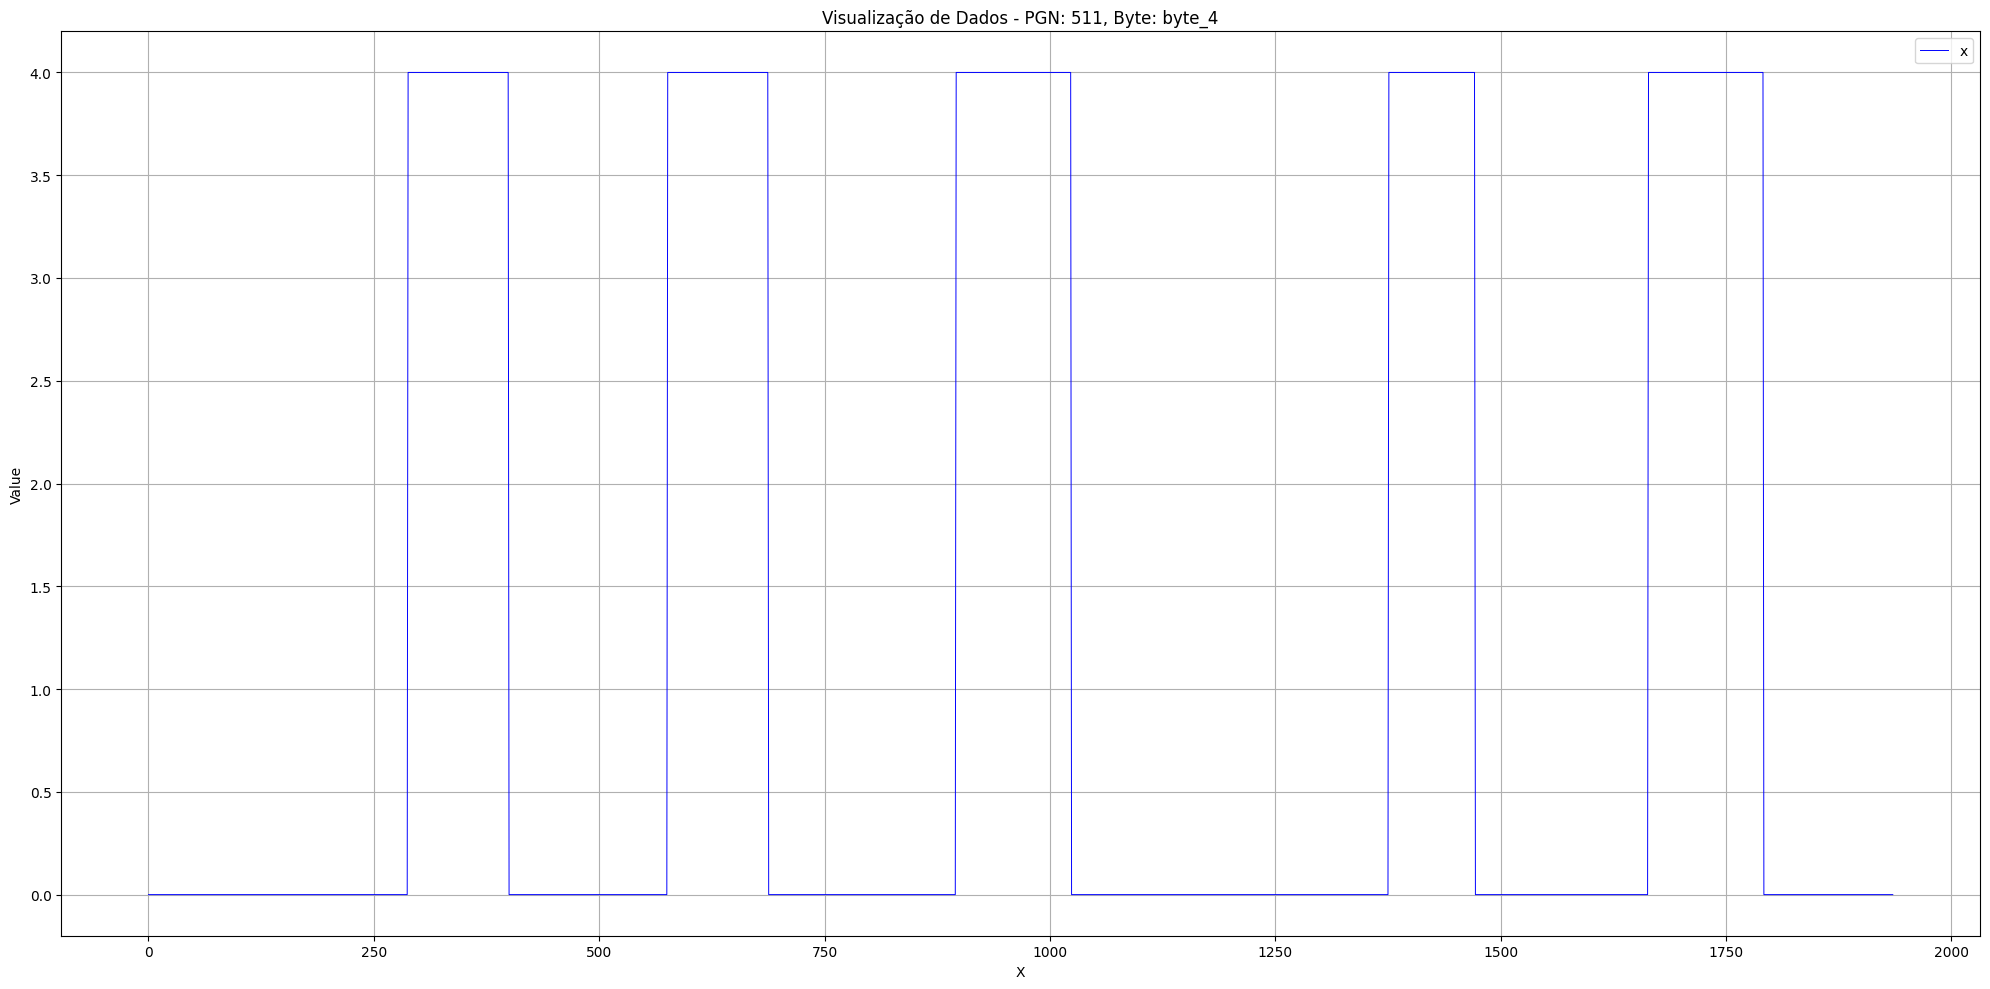

In [86]:
vizdata(df_expanded_four)

# Can-SquareWaves

In [112]:
def ui_load_can_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo .CAN ou .TXT",
            filetypes=(("CAN files", "*.can"), ("TXT files", "*.txt"), ("all files", "*.*"))
        )
    if file_path:
        df = can_filetodataframe(file_path)  # Carrega os dados do arquivo
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [88]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 bytes
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal, ignorando inválidos
        byte_list = [int(byte, 16) if is_valid_hex(byte) else 0 for byte in byte_list]

        return byte_list  # Retorna a lista de bytes convertida
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")

In [89]:
def is_valid_hex(value):
    """Função para verificar se o valor é hexadecimal válido"""
    try:
        int(value, 16)
        return True
    except ValueError:
        return False

In [90]:
def can_filetodataframe(file_path):
    try:
        # Ler o arquivo .txt linha a linha
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Separar as colunas por ';' e montar a lista de dados
        data = []
        for line in lines:
            # Ignorar as linhas de cabeçalho e as que não têm a quantidade esperada de colunas
            if line.startswith("//") or "Logging" in line or "Microchip" in line:
                continue

            # Dividir os valores por ';'
            parts = line.strip().split(';')

            # Garantir que tenha o número mínimo de colunas para processar (pelo menos 5)
            if len(parts) < 5:
                continue

            # Extrair o ID e os bytes
            pgn = parts[2]  # PGN (ID)
            byte_count = int(parts[3])  # Número de bytes
            byte_values = parts[4:4 + byte_count]  # Extraindo os bytes reais

            # Preencher com '00' caso não tenha 8 bytes
            if len(byte_values) < 8:
                byte_values.extend(['00'] * (8 - len(byte_values)))

            # Adicionar a linha processada (PGN + 8 bytes)
            data.append([pgn] + byte_values[:8])  # Garantir que tenha no máximo 8 bytes

        # Converter a lista de dados em um DataFrame
        df = pd.DataFrame(data, columns=['pgn', 'Byte 1', 'Byte 2', 'Byte 3', 'Byte 4',
                                         'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8'])

        # Aplicar a conversão de hexadecimal para decimal nas colunas de bytes e no PGN
        for i in range(1, 9):
            df[f'Byte {i}'] = df[f'Byte {i}'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        # Converter o PGN de hexadecimal para decimal
        df['pgn'] = df['pgn'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        return df

    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None

In [91]:
def filtrar_dataframe_can(df, pgn, byte):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == pgn]  # Se pgn for uma string hexadecimal
            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

# Corolla Hybrid
## Freio

In [92]:
filtro_byte = 5
filtro_pgn = 865
filtro_byte = f'Byte {filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

Byte 5 e 865


In [93]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_5 = ui_load_can_archive("Spy Can Input CSV/corolla/freio_5x_logFile.CAN")
df_raw_5.head()

,pgn,Byte 1,Byte 2,Byte 3,Byte 4,Byte 5,Byte 6,Byte 7,Byte 8
0,608,0,0,10,249,157,0,134,144
1,740,160,0,0,0,139,0,0,0
2,32,0,0,7,43,0,0,0,0
3,36,2,0,2,0,66,4,128,246
4,37,15,194,0,0,144,0,0,142


In [94]:
filtered_df_five = filtrar_dataframe_can(df_raw_5, filtro_pgn, filtro_byte)

In [95]:
df_expanded_five = rows_replicate_dataframes(filtered_df_five, target_size=2000)

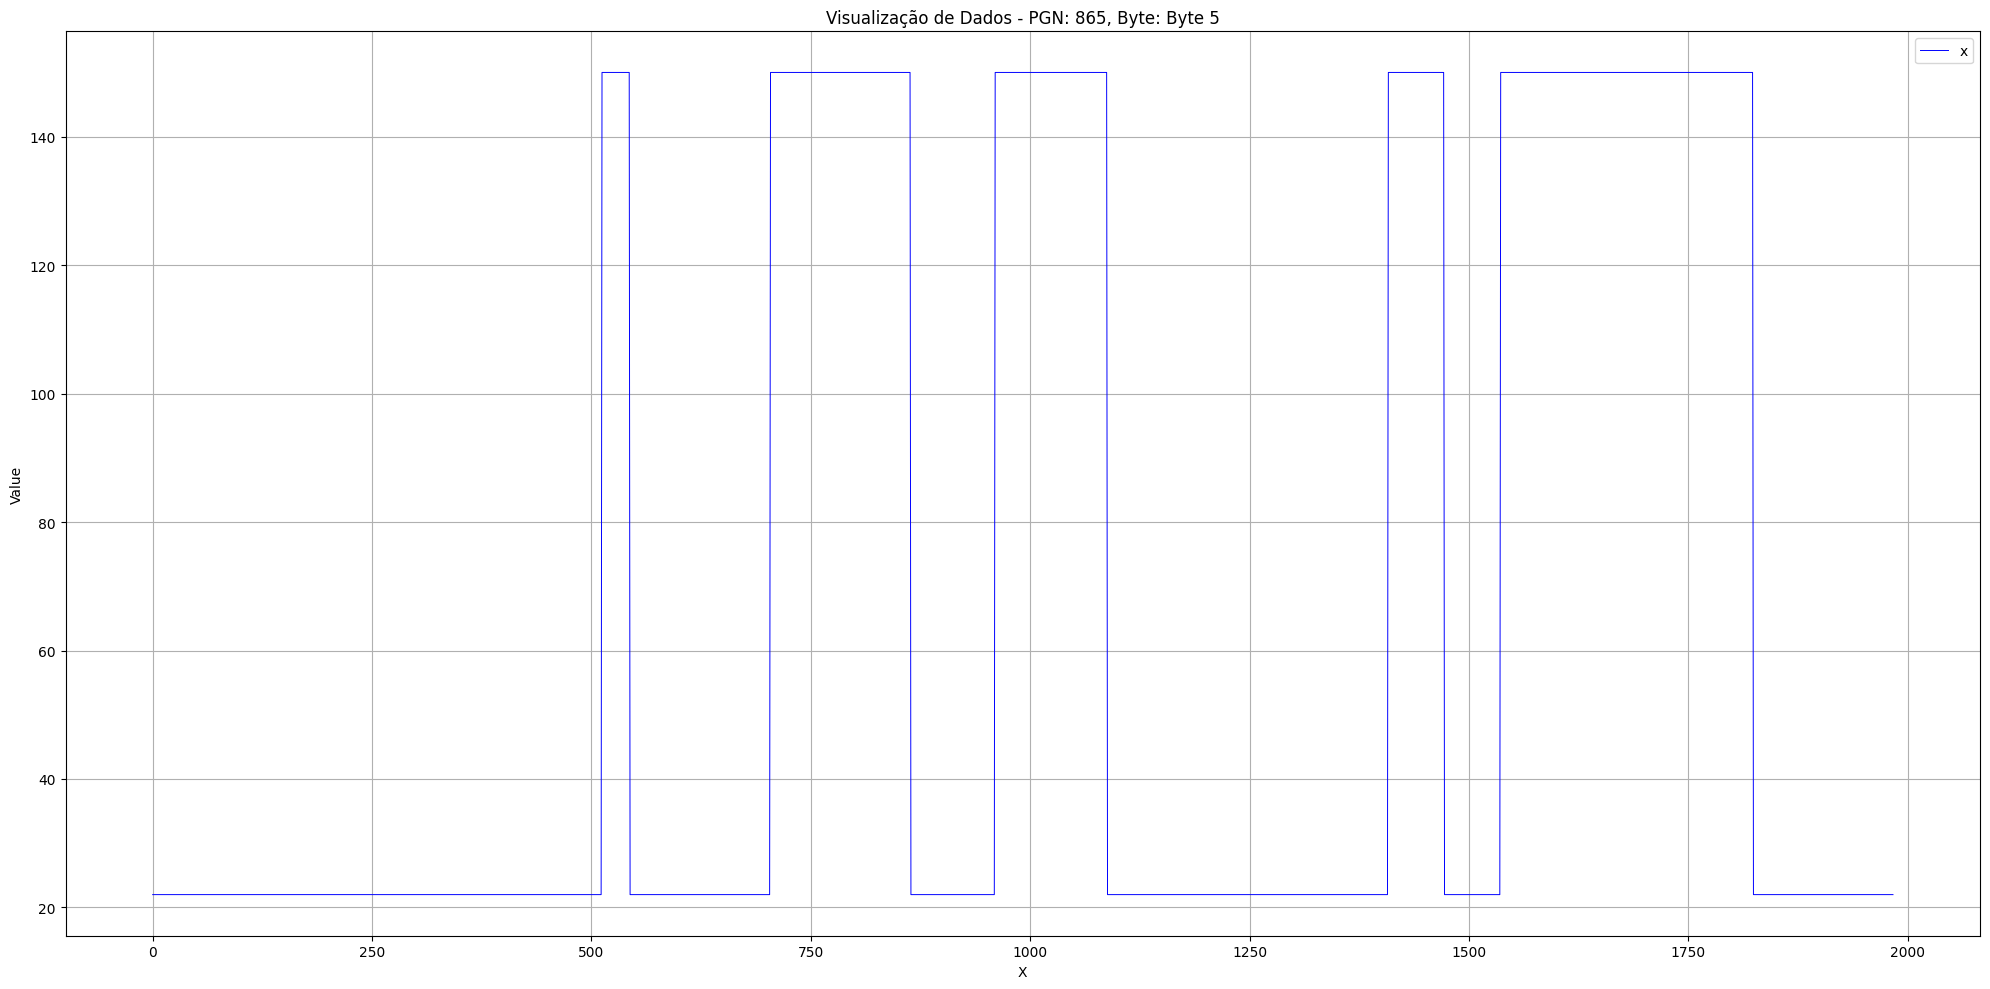

In [96]:
vizdata(df_expanded_five)

In [97]:
byte = 1
filtro_pgn = 971
filtro_byte = f'Byte {byte}'
print(f"{filtro_byte} e {filtro_pgn}")

Byte 1 e 971


In [98]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_6 = ui_load_can_archive("Spy Can Input CSV/corolla/limpador_5x_Corolla_logFile.CAN")
filtered_df_six = filtrar_dataframe_can(df_raw_6, filtro_pgn, filtro_byte)

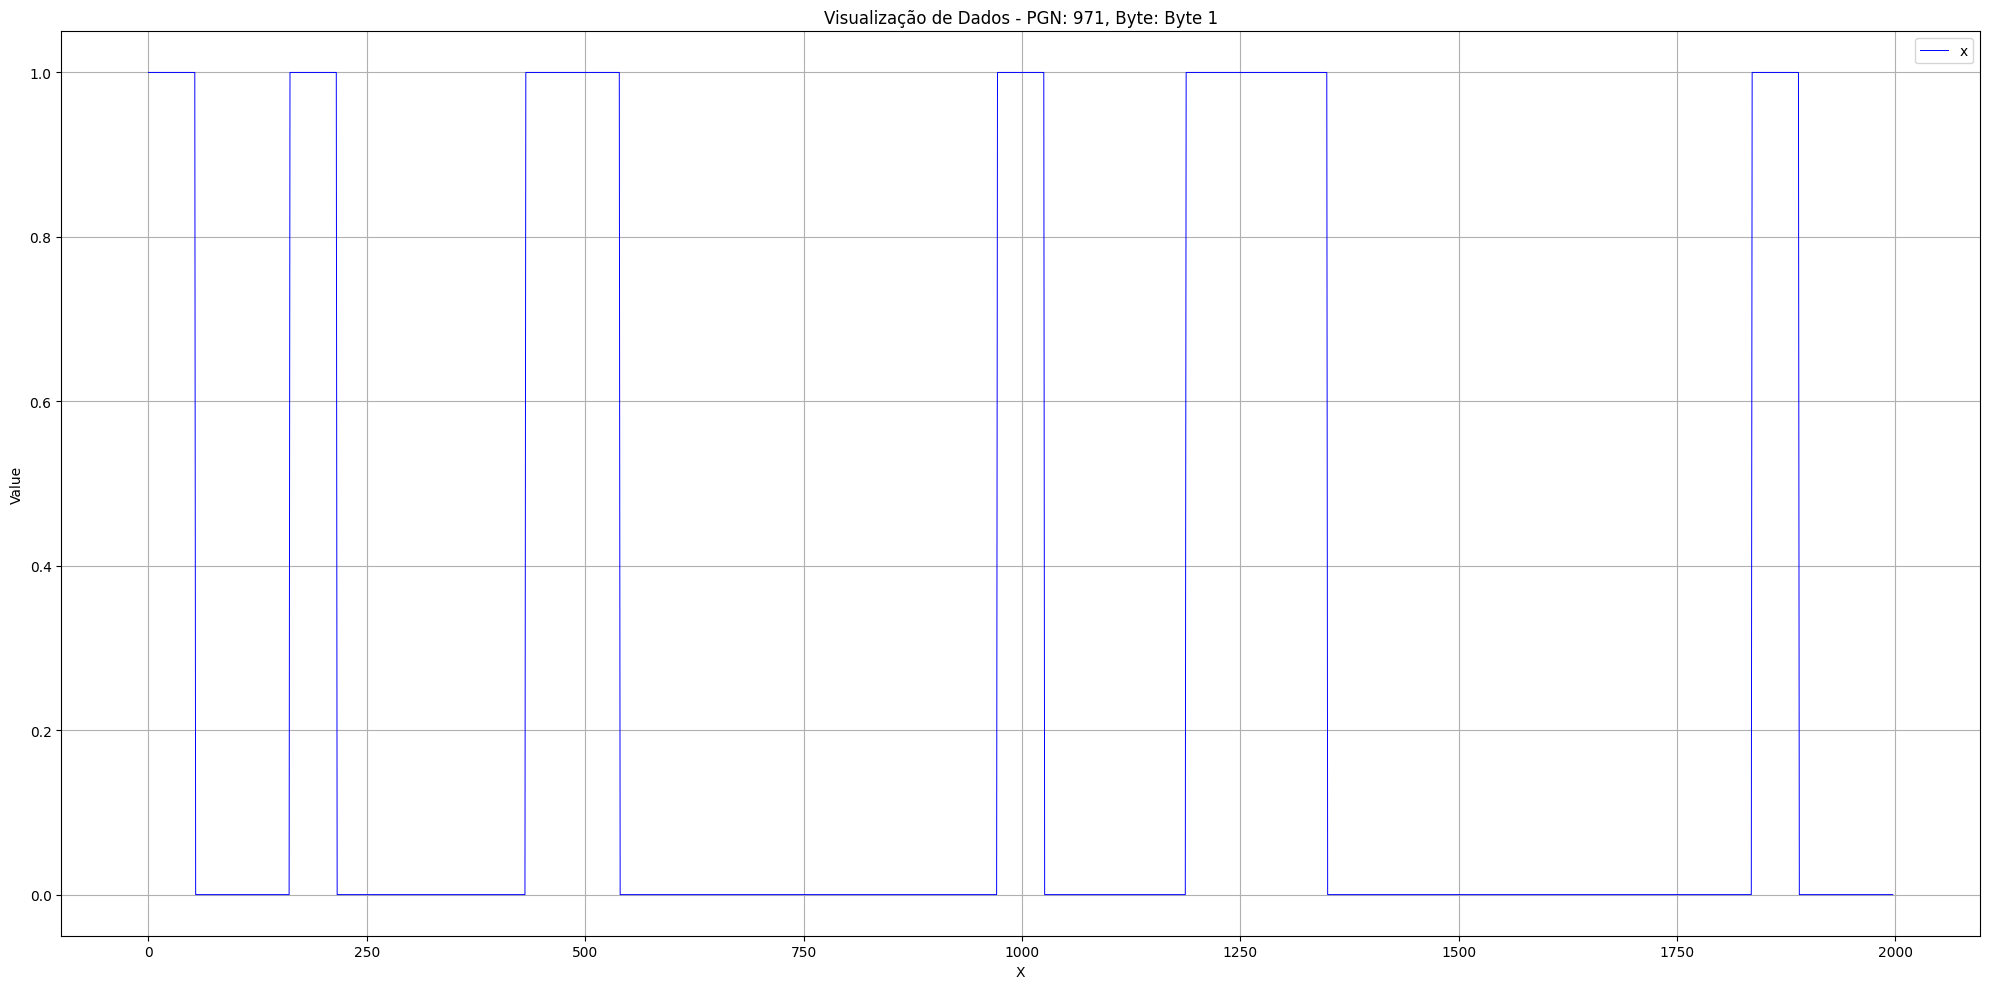

In [99]:
df_expanded_six = rows_replicate_dataframes(filtered_df_six, target_size=2000)
vizdata(df_expanded_six)

In [133]:
byte = '2'
filtro_pgn = 502
filtro_byte = f'byte_{byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_2 e 502


In [134]:
os.chdir("C:/Users/user/Documents/Repositórios/CSI-Can_Signal_Identifier/")
df_raw_11 = ui_load_ixxt_archive("Spy Can Input CSV/ixxat_data/Duster 2016/RenaultDuster_2016_RPMPulso_3000RPM.CSV")
filtered_df_eleven = filtrar_dataframe_can(df_raw_11, filtro_pgn, filtro_byte)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0       0       0       0       0
1         255     148     255     196       0       0       0       0
2         199       4      54      65      20     152     168      73
3           2      95      42     107       6       0       0       0
4           0     217      80       0     144     128       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
33545     148       0     233      58     197      76     184     177
33546     255     255     255     255     255     240       0       0
33547      95       0       0     255       0       0       0       0
33548       0       0       0       0       0       0       0       0
33549     128     133       2       0     160       0       0       0

[33550 rows x 8 columns]


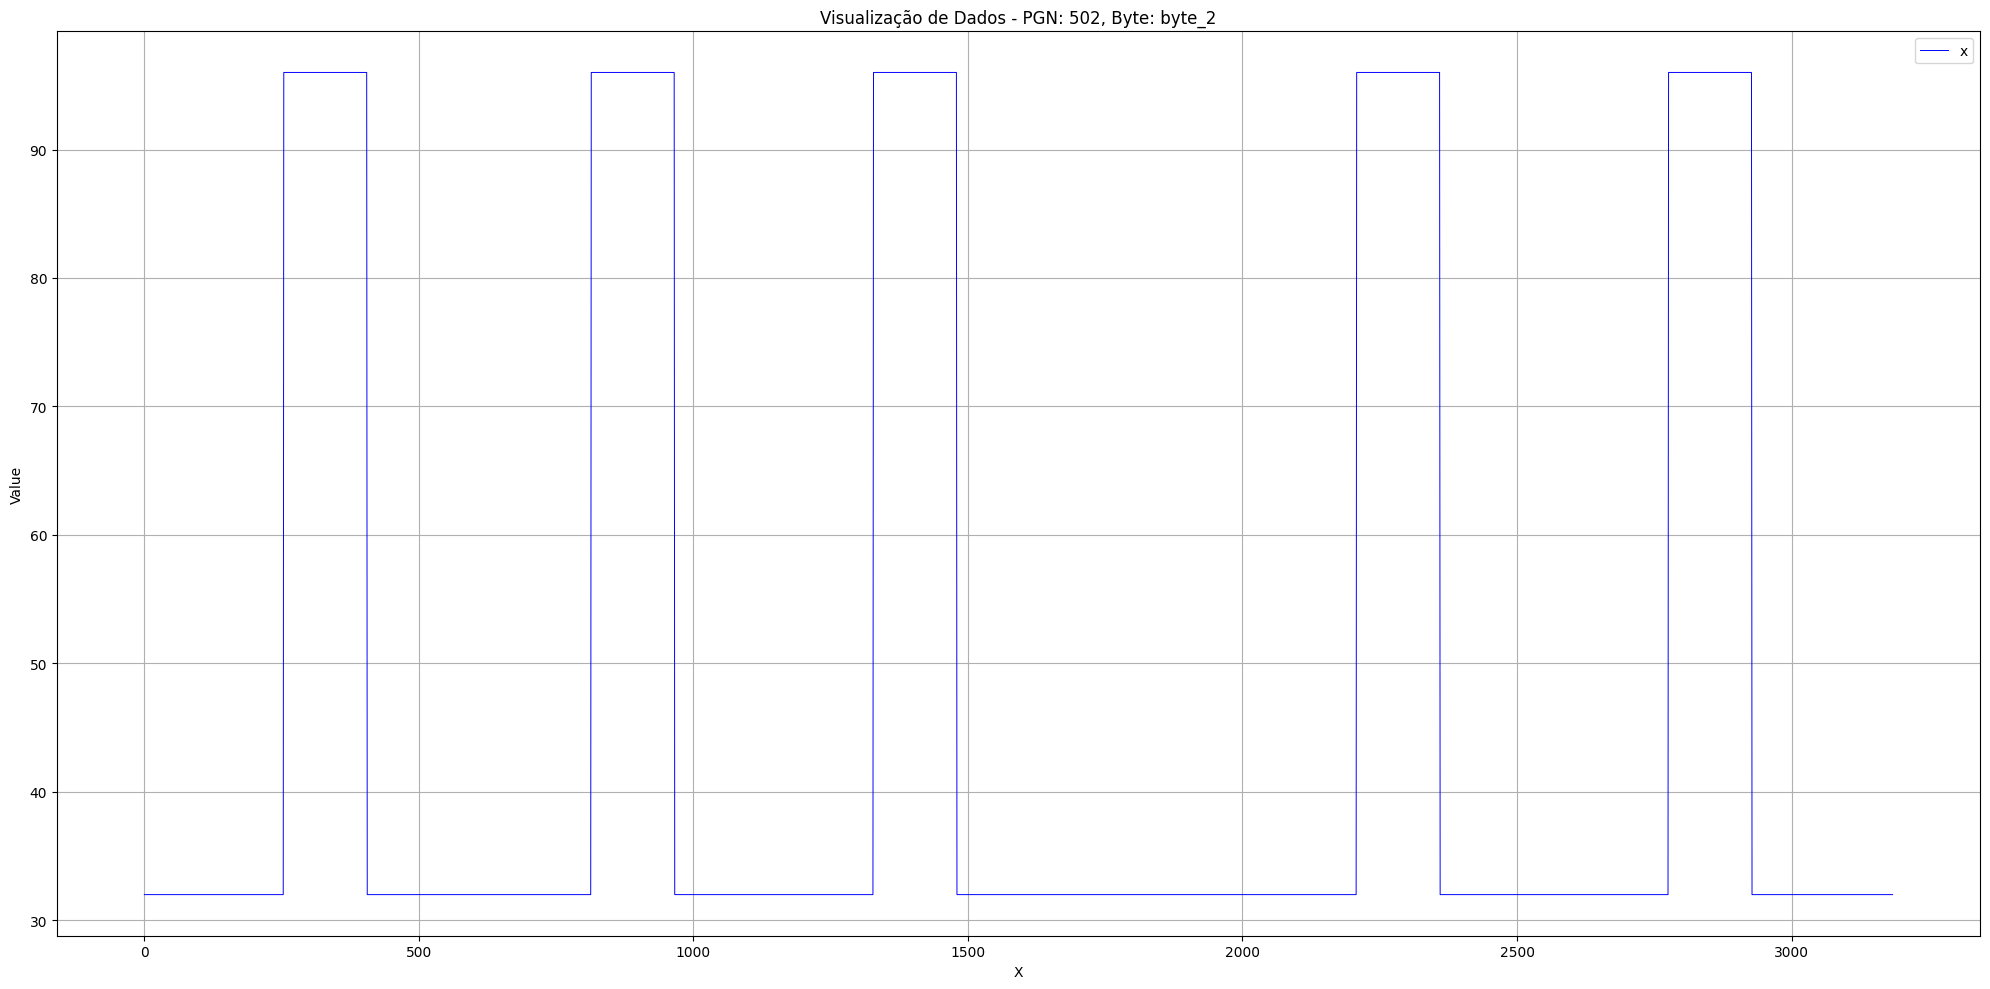

In [144]:
vizdata(filtered_df_eleven)

# Cluster

In [145]:
df_list = [filtered_df_one, df_expanded_two, df_expanded_three, df_expanded_four, df_expanded_five, df_expanded_six, df_expanded_seven, df_expanded_eight,df_expanded_nine, df_expanded_ten, filtered_df_eleven]
df_concatenate = concatenate_dataframes(df_list)

In [146]:
df_decimado = decimacao_dinamica(df_concatenate, 'x', 1000)
normalized_df = normalizar_dataframe(df_decimado)

dataframe antes decimaçao:                                                    x
0   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
2   [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...
3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4   [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...
5   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
6   [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...
7   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
8   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
9   [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
10  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...
Lista maior que o tamanho' fixo (2907 > 1000). Aplicando decimação.
Lista decimada: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

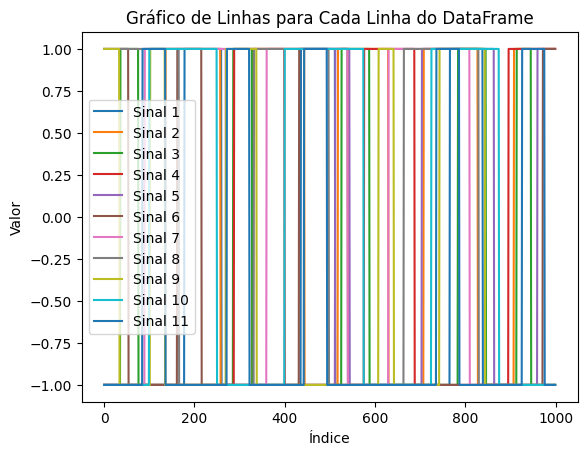

In [147]:
labeled_df = rotular_df(normalized_df, "Onda Quadrada")
plot_line_for_each_row(labeled_df)

In [142]:
print(labeled_df.tail())

                                                    x  label
6   [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
7   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
8   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
9   [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
10  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1


In [105]:
def save_df_train(train_df):
    if train_df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame de treino completo"
    )

    if save_path:
        train_df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame de treino salvo com sucesso!")

In [106]:
def ui_load_can_archive():
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    file_path = filedialog.askopenfilename(
        title="Selecione o arquivo",
        filetypes=(("TXT files", "*.txt"), ("all files", "*.*"))
    )
    if file_path:
        can_data = can_filetodataframe(file_path)  # Carrega os dados do arquivo terceiro tipo
        messagebox.showinfo("Sucesso", f"Arquivo '{file_path}' carregado com sucesso!")
    else:
        messagebox.showwarning("Aviso", "Nenhum arquivo foi selecionado.")


In [107]:
def can_process_data(data_hex):
    bytes_list = data_hex.strip().split()

    # Preencher com '00' até que tenha 8 bytes
    if len(bytes_list) < 8:
        bytes_list.extend(['00'] * (8 - len(bytes_list)))

    return bytes_list[:8]  # Garantir que tenha no máximo 8 bytes

In [148]:
save_df_train(labeled_df)